In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

#from utils import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data preprocessing

In [ ]:
data = np.genfromtxt('./train.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_y = data[:,0]
data = np.delete(data, (0), axis=1)
data_np_x = data / 255


pos = int(data_np_x.shape[0] * 0.9)

train_np_y = data_np_y[:pos]
train_np_x = data_np_x[:pos]
test_np_y = data_np_y[pos:]
test_np_x = data_np_x[pos:]

print ("Y: {}".format(train_np_y[:10]))

In [ ]:
print (data_np_x.shape, data_np_y.shape)
print (train_np_x.shape, train_np_y.shape)
print (test_np_x.shape, test_np_y.shape)

In [4]:
print (test_np_x.shape, test_np_y.shape)

(4200, 784) (4200,)


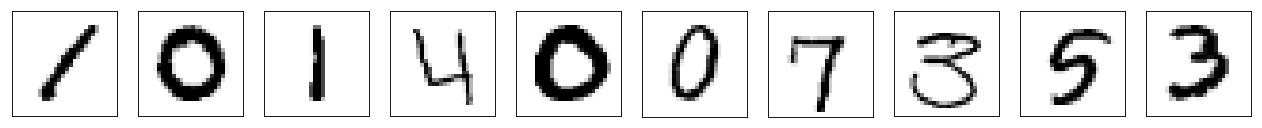

[1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [5]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = train_np_x[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (train_np_y[:10])

In [6]:
def normalize(x):
    x = (x - 0.1307) / 0.3081    
    return x

In [7]:
train_x = torch.Tensor(np.expand_dims(normalize(train_np_x), axis=1))
train_y = torch.LongTensor(train_np_y)

test_x = torch.Tensor(np.expand_dims(normalize(test_np_x), axis=1))
test_y = torch.LongTensor(test_np_y)

## Neural network

In [8]:
def loader(x, y, batch_size=32):
    for i in range(0, x.size(0) - 1, batch_size):
        data = x[i:i+batch_size]
        if data.shape[0] == batch_size:
            data = data.reshape(batch_size, 1, 28, 28)
            targets = y[i:i+batch_size]

            yield data, targets
    

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []        
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=5e-5, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 32, 3], bn=batchnorm)
        self._conv2 = ConvLayer([32, 64, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([64*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):        
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_x)
    for batch_idx, (data, target) in enumerate(loader(train_x, train_y)):
        for model in models.values():                             
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [13]:
def test(models, log=None):
    test_size = len(test_x)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(test_x, test_y):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [14]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [15]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [16]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/37800 (0%)]	Losses bn: 2.392093 drop: 2.336140 plain: 2.323187
Train Epoch: 1 [6400/37800 (1%)]	Losses bn: 1.591996 drop: 2.081258 plain: 2.056485
Train Epoch: 1 [12800/37800 (1%)]	Losses bn: 1.307419 drop: 1.819666 plain: 1.755378
Train Epoch: 1 [19200/37800 (2%)]	Losses bn: 0.823513 drop: 1.185665 plain: 1.124634
Train Epoch: 1 [25600/37800 (2%)]	Losses bn: 0.895865 drop: 1.210897 plain: 1.138555
Train Epoch: 1 [32000/37800 (3%)]	Losses bn: 0.711713 drop: 0.818733 plain: 0.823962
Train Epoch: 1 [37792/37800 (3%)]	Losses bn: 0.563990 drop: 0.761150 plain: 0.734218


/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
bn: Loss: 0.5222	Accuracy: 3875.0/4200 (92%)
drop: Loss: 0.6520	Accuracy: 3580.0/4200 (85%)
plain: Loss: 0.6270	Accuracy: 3631.0/4200 (86%)

Train Epoch: 2 [0/37800 (0%)]	Losses bn: 0.466278 drop: 0.588315 plain: 0.536954
Train Epoch: 2 [6400/37800 (1%)]	Losses bn: 0.340808 drop: 0.369763 plain: 0.358715
Train Epoch: 2 [12800/37800 (1%)]	Losses bn: 0.507216 drop: 0.676040 plain: 0.656819
Train Epoch: 2 [19200/37800 (2%)]	Losses bn: 0.256668 drop: 0.263278 plain: 0.267215
Train Epoch: 2 [25600/37800 (2%)]	Losses bn: 0.390311 drop: 0.646524 plain: 0.607104
Train Epoch: 2 [32000/37800 (3%)]	Losses bn: 0.316425 drop: 0.389902 plain: 0.402457
Train Epoch: 2 [37792/37800 (3%)]	Losses bn: 0.275606 drop: 0.428960 plain: 0.419263
Test set:
bn: Loss: 0.2657	Accuracy: 3973.0/4200 (95%)
drop: Loss: 0.3757	Accuracy: 3807.0/4200 (91%)
plain: Loss: 0.3651	Accuracy: 3819.0/4200 (91%)

Train Epoch: 3 [0/37800 (0%)]	Losses bn: 0.192105 drop: 0.310417 plain: 0.280580
Train Epoch: 3 [6400/37800 

Train Epoch: 13 [0/37800 (0%)]	Losses bn: 0.012134 drop: 0.018646 plain: 0.021041
Train Epoch: 13 [6400/37800 (1%)]	Losses bn: 0.018601 drop: 0.022601 plain: 0.020965
Train Epoch: 13 [12800/37800 (1%)]	Losses bn: 0.081125 drop: 0.162211 plain: 0.176807
Train Epoch: 13 [19200/37800 (2%)]	Losses bn: 0.031624 drop: 0.038767 plain: 0.048138
Train Epoch: 13 [25600/37800 (2%)]	Losses bn: 0.164956 drop: 0.111663 plain: 0.127758
Train Epoch: 13 [32000/37800 (3%)]	Losses bn: 0.041262 drop: 0.063882 plain: 0.071435
Train Epoch: 13 [37792/37800 (3%)]	Losses bn: 0.031276 drop: 0.048241 plain: 0.043119
Test set:
bn: Loss: 0.0565	Accuracy: 4123.0/4200 (98%)
drop: Loss: 0.0804	Accuracy: 4091.0/4200 (97%)
plain: Loss: 0.0832	Accuracy: 4096.0/4200 (98%)

Train Epoch: 14 [0/37800 (0%)]	Losses bn: 0.010711 drop: 0.014999 plain: 0.018088
Train Epoch: 14 [6400/37800 (1%)]	Losses bn: 0.017897 drop: 0.022012 plain: 0.020016
Train Epoch: 14 [12800/37800 (1%)]	Losses bn: 0.077106 drop: 0.152072 plain: 0.166745

Train Epoch: 24 [6400/37800 (1%)]	Losses bn: 0.013345 drop: 0.015310 plain: 0.013727
Train Epoch: 24 [12800/37800 (1%)]	Losses bn: 0.045483 drop: 0.103308 plain: 0.109192
Train Epoch: 24 [19200/37800 (2%)]	Losses bn: 0.014850 drop: 0.027794 plain: 0.032815
Train Epoch: 24 [25600/37800 (2%)]	Losses bn: 0.165725 drop: 0.078482 plain: 0.076689
Train Epoch: 24 [32000/37800 (3%)]	Losses bn: 0.023260 drop: 0.033783 plain: 0.042648
Train Epoch: 24 [37792/37800 (3%)]	Losses bn: 0.018360 drop: 0.040090 plain: 0.022434
Test set:
bn: Loss: 0.0429	Accuracy: 4131.0/4200 (98%)
drop: Loss: 0.0525	Accuracy: 4125.0/4200 (98%)
plain: Loss: 0.0539	Accuracy: 4126.0/4200 (98%)

Train Epoch: 25 [0/37800 (0%)]	Losses bn: 0.005198 drop: 0.003959 plain: 0.006967
Train Epoch: 25 [6400/37800 (1%)]	Losses bn: 0.012994 drop: 0.014721 plain: 0.013332
Train Epoch: 25 [12800/37800 (1%)]	Losses bn: 0.042790 drop: 0.100478 plain: 0.105012
Train Epoch: 25 [19200/37800 (2%)]	Losses bn: 0.013904 drop: 0.027269 plain: 0.03

Train Epoch: 35 [6400/37800 (1%)]	Losses bn: 0.009835 drop: 0.009801 plain: 0.010579
Train Epoch: 35 [12800/37800 (1%)]	Losses bn: 0.021223 drop: 0.075612 plain: 0.071387
Train Epoch: 35 [19200/37800 (2%)]	Losses bn: 0.008532 drop: 0.023591 plain: 0.024497
Train Epoch: 35 [25600/37800 (2%)]	Losses bn: 0.110460 drop: 0.061016 plain: 0.057947
Train Epoch: 35 [32000/37800 (3%)]	Losses bn: 0.013336 drop: 0.021519 plain: 0.026586
Train Epoch: 35 [37792/37800 (3%)]	Losses bn: 0.013214 drop: 0.036160 plain: 0.016824
Test set:
bn: Loss: 0.0382	Accuracy: 4132.0/4200 (98%)
drop: Loss: 0.0425	Accuracy: 4133.0/4200 (98%)
plain: Loss: 0.0435	Accuracy: 4137.0/4200 (98%)

Train Epoch: 36 [0/37800 (0%)]	Losses bn: 0.003608 drop: 0.002370 plain: 0.004728
Train Epoch: 36 [6400/37800 (1%)]	Losses bn: 0.009620 drop: 0.009422 plain: 0.010309
Train Epoch: 36 [12800/37800 (1%)]	Losses bn: 0.019783 drop: 0.073209 plain: 0.068738
Train Epoch: 36 [19200/37800 (2%)]	Losses bn: 0.008179 drop: 0.023202 plain: 0.02

Train Epoch: 46 [6400/37800 (1%)]	Losses bn: 0.005377 drop: 0.006552 plain: 0.008134
Train Epoch: 46 [12800/37800 (1%)]	Losses bn: 0.009265 drop: 0.050554 plain: 0.046176
Train Epoch: 46 [19200/37800 (2%)]	Losses bn: 0.005354 drop: 0.019671 plain: 0.019979
Train Epoch: 46 [25600/37800 (2%)]	Losses bn: 0.039422 drop: 0.045342 plain: 0.046776
Train Epoch: 46 [32000/37800 (3%)]	Losses bn: 0.009256 drop: 0.014903 plain: 0.017525
Train Epoch: 46 [37792/37800 (3%)]	Losses bn: 0.008134 drop: 0.031224 plain: 0.013662
Test set:
bn: Loss: 0.0357	Accuracy: 4138.0/4200 (99%)
drop: Loss: 0.0374	Accuracy: 4141.0/4200 (99%)
plain: Loss: 0.0384	Accuracy: 4145.0/4200 (99%)

Train Epoch: 47 [0/37800 (0%)]	Losses bn: 0.002524 drop: 0.001890 plain: 0.003977
Train Epoch: 47 [6400/37800 (1%)]	Losses bn: 0.004987 drop: 0.006332 plain: 0.007927
Train Epoch: 47 [12800/37800 (1%)]	Losses bn: 0.008398 drop: 0.048502 plain: 0.044283
Train Epoch: 47 [19200/37800 (2%)]	Losses bn: 0.005053 drop: 0.019385 plain: 0.01

Train Epoch: 57 [6400/37800 (1%)]	Losses bn: 0.002370 drop: 0.004622 plain: 0.006060
Train Epoch: 57 [12800/37800 (1%)]	Losses bn: 0.003812 drop: 0.031612 plain: 0.028888
Train Epoch: 57 [19200/37800 (2%)]	Losses bn: 0.002923 drop: 0.016694 plain: 0.016045
Train Epoch: 57 [25600/37800 (2%)]	Losses bn: 0.010306 drop: 0.032277 plain: 0.036315
Train Epoch: 57 [32000/37800 (3%)]	Losses bn: 0.005017 drop: 0.010383 plain: 0.011814
Train Epoch: 57 [37792/37800 (3%)]	Losses bn: 0.003997 drop: 0.026019 plain: 0.011286
Test set:
bn: Loss: 0.0339	Accuracy: 4145.0/4200 (99%)
drop: Loss: 0.0346	Accuracy: 4142.0/4200 (99%)
plain: Loss: 0.0356	Accuracy: 4143.0/4200 (99%)

Train Epoch: 58 [0/37800 (0%)]	Losses bn: 0.001569 drop: 0.001678 plain: 0.003603
Train Epoch: 58 [6400/37800 (1%)]	Losses bn: 0.002208 drop: 0.004482 plain: 0.005900
Train Epoch: 58 [12800/37800 (1%)]	Losses bn: 0.003382 drop: 0.030347 plain: 0.027733
Train Epoch: 58 [19200/37800 (2%)]	Losses bn: 0.002729 drop: 0.016426 plain: 0.01

Train Epoch: 68 [6400/37800 (1%)]	Losses bn: 0.001053 drop: 0.003349 plain: 0.004460
Train Epoch: 68 [12800/37800 (1%)]	Losses bn: 0.001478 drop: 0.020303 plain: 0.019007
Train Epoch: 68 [19200/37800 (2%)]	Losses bn: 0.001243 drop: 0.014268 plain: 0.012953
Train Epoch: 68 [25600/37800 (2%)]	Losses bn: 0.003541 drop: 0.022440 plain: 0.027243
Train Epoch: 68 [32000/37800 (3%)]	Losses bn: 0.002213 drop: 0.007383 plain: 0.008318
Train Epoch: 68 [37792/37800 (3%)]	Losses bn: 0.001790 drop: 0.020928 plain: 0.009159
Test set:
bn: Loss: 0.0334	Accuracy: 4142.0/4200 (99%)
drop: Loss: 0.0331	Accuracy: 4143.0/4200 (99%)
plain: Loss: 0.0341	Accuracy: 4142.0/4200 (99%)

Train Epoch: 69 [0/37800 (0%)]	Losses bn: 0.000731 drop: 0.001476 plain: 0.003236
Train Epoch: 69 [6400/37800 (1%)]	Losses bn: 0.000955 drop: 0.003253 plain: 0.004326
Train Epoch: 69 [12800/37800 (1%)]	Losses bn: 0.001393 drop: 0.019522 plain: 0.018316
Train Epoch: 69 [19200/37800 (2%)]	Losses bn: 0.001207 drop: 0.014126 plain: 0.01

Train Epoch: 79 [6400/37800 (1%)]	Losses bn: 0.000379 drop: 0.002471 plain: 0.003237
Train Epoch: 79 [12800/37800 (1%)]	Losses bn: 0.000597 drop: 0.013859 plain: 0.012896
Train Epoch: 79 [19200/37800 (2%)]	Losses bn: 0.000491 drop: 0.012244 plain: 0.010165
Train Epoch: 79 [25600/37800 (2%)]	Losses bn: 0.001172 drop: 0.015484 plain: 0.020367
Train Epoch: 79 [32000/37800 (3%)]	Losses bn: 0.000791 drop: 0.005362 plain: 0.005971
Train Epoch: 79 [37792/37800 (3%)]	Losses bn: 0.000638 drop: 0.016127 plain: 0.007258
Test set:
bn: Loss: 0.0342	Accuracy: 4141.0/4200 (99%)
drop: Loss: 0.0322	Accuracy: 4146.0/4200 (99%)
plain: Loss: 0.0333	Accuracy: 4143.0/4200 (99%)

Train Epoch: 80 [0/37800 (0%)]	Losses bn: 0.000307 drop: 0.001240 plain: 0.002821
Train Epoch: 80 [6400/37800 (1%)]	Losses bn: 0.000340 drop: 0.002409 plain: 0.003141
Train Epoch: 80 [12800/37800 (1%)]	Losses bn: 0.000529 drop: 0.013434 plain: 0.012479
Train Epoch: 80 [19200/37800 (2%)]	Losses bn: 0.000440 drop: 0.012031 plain: 0.00

Train Epoch: 90 [6400/37800 (1%)]	Losses bn: 0.000107 drop: 0.001845 plain: 0.002357
Train Epoch: 90 [12800/37800 (1%)]	Losses bn: 0.000201 drop: 0.010047 plain: 0.009069
Train Epoch: 90 [19200/37800 (2%)]	Losses bn: 0.000170 drop: 0.009484 plain: 0.007522
Train Epoch: 90 [25600/37800 (2%)]	Losses bn: 0.000350 drop: 0.011187 plain: 0.014804
Train Epoch: 90 [32000/37800 (3%)]	Losses bn: 0.000274 drop: 0.003978 plain: 0.004322
Train Epoch: 90 [37792/37800 (3%)]	Losses bn: 0.000229 drop: 0.011948 plain: 0.005711
Test set:
bn: Loss: 0.0360	Accuracy: 4144.0/4200 (99%)
drop: Loss: 0.0317	Accuracy: 4148.0/4200 (99%)
plain: Loss: 0.0329	Accuracy: 4145.0/4200 (99%)

Train Epoch: 91 [0/37800 (0%)]	Losses bn: 0.000128 drop: 0.000978 plain: 0.002293
Train Epoch: 91 [6400/37800 (1%)]	Losses bn: 0.000092 drop: 0.001793 plain: 0.002287
Train Epoch: 91 [12800/37800 (1%)]	Losses bn: 0.000183 drop: 0.009788 plain: 0.008831
Train Epoch: 91 [19200/37800 (2%)]	Losses bn: 0.000148 drop: 0.009156 plain: 0.00

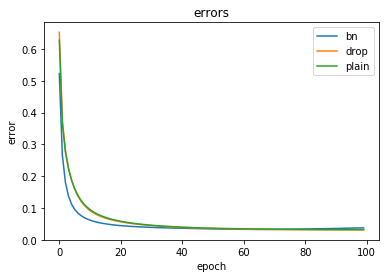

In [17]:
plot_graphs(test_log, 'loss')

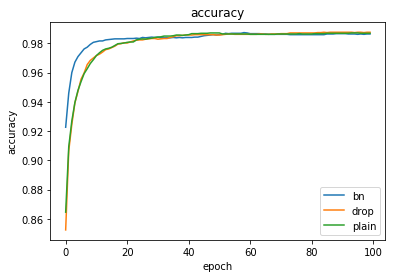

In [18]:
plot_graphs(test_log, 'accuracy')

## Submission

In [26]:
data = np.genfromtxt('./test.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_x = data / 255

testing_x = torch.Tensor(np.expand_dims(normalize(data_np_x), axis=1))
testing_y = torch.LongTensor(np.zeros((testing_x.shape[0], 1)))

In [27]:
print (testing_x.shape)

torch.Size([28000, 1, 784])


In [28]:
answers = np.empty((0, 10))
model = models['drop']
print (model)

for batch_idx, (data, target) in enumerate(loader(testing_x, testing_y)):
    output = model(data)  
    output_np = output.detach().numpy()        
    answers = np.vstack((answers, output_np))
        
print (answers.shape)

Net(
  (_conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
  )
  (_conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Sigmoid()
    )
  )
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=3136, out_features=10, bias=True)
    )
  )
)
(28000, 10)


In [29]:
vals = np.argmax(answers, axis=1)

In [30]:
print (answers[:100])

[[-7.16269875e+00 -1.60121822e+01  1.06884661e+01 -6.47136688e+00
  -1.17631922e+01 -1.21434679e+01 -1.63155842e+01 -8.65103340e+00
  -7.29650211e+00 -7.87598944e+00]
 [ 7.96404457e+00 -1.54184065e+01 -4.63093805e+00 -7.94373655e+00
  -1.14978619e+01 -6.89394712e+00 -5.63781691e+00 -7.37076187e+00
  -1.10100842e+01 -7.42037439e+00]
 [-2.00090389e+01 -1.17662468e+01 -3.89059043e+00 -6.97501516e+00
  -1.54494703e+00 -9.46545982e+00 -1.91596947e+01 -9.47061825e+00
  -2.20920134e+00  8.34610271e+00]
 [ 3.83594656e+00 -1.72275906e+01 -1.30564487e+00 -7.40027237e+00
  -5.06602144e+00 -1.12251835e+01 -7.38695240e+00 -4.07968378e+00
  -5.74912405e+00  1.89173996e+00]
 [-1.30997896e+01 -1.16446657e+01 -9.35777426e-01  6.50771093e+00
  -1.47982273e+01 -6.08990860e+00 -1.18943367e+01 -1.00861454e+01
  -3.96348596e+00 -6.14569759e+00]
 [-1.38568010e+01 -1.71890221e+01 -7.97658348e+00 -5.32540798e+00
  -8.81492329e+00 -5.05572462e+00 -2.24025593e+01  3.83194304e+00
  -7.94081116e+00 -3.24330986e-01

In [31]:
print (vals[:1000])

[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7 6 8 8 3 8 2 1 2 2 0 4 1 7 0 0 0 1 9 0 1 6 5 8 8
 2 8 3 9 2 3 5 4 1 0 9 2 4 3 6 7 2 0 6 6 1 4 3 9 7 4 0 9 2 0 7 3 0 5 0 8 0
 0 4 7 1 7 1 1 3 3 3 7 2 8 6 3 8 7 8 4 3 5 6 0 0 0 3 1 3 6 4 3 4 5 5 8 7 7
 2 8 4 3 5 6 5 3 7 5 7 8 3 0 4 5 1 3 7 6 3 0 2 7 8 6 1 3 7 4 1 2 4 8 5 2 4
 9 2 1 6 0 6 1 4 9 6 0 9 7 6 9 1 9 0 9 9 0 8 4 6 2 0 9 3 6 3 2 1 6 3 4 2 3
 1 2 2 0 4 6 1 0 0 4 9 1 7 3 2 3 8 6 8 6 2 8 5 5 4 8 3 5 9 7 1 3 8 4 5 1 4
 5 6 3 3 5 7 0 6 8 3 1 6 0 6 3 9 3 1 5 8 4 0 9 2 0 5 3 7 1 9 9 5 7 7 9 9 6
 3 0 3 3 6 9 8 2 6 3 7 1 4 5 8 5 9 0 0 3 8 4 1 8 4 1 1 9 8 4 5 1 5 3 6 3 1
 3 0 9 0 0 6 0 6 3 1 8 6 0 6 5 2 2 6 7 7 2 5 8 3 9 2 7 8 6 3 8 4 2 3 8 1 6
 4 8 7 9 7 6 9 5 3 7 6 5 5 4 2 6 2 1 3 7 1 7 9 9 6 1 1 1 7 3 9 7 6 1 1 1 9
 3 8 5 5 0 4 1 2 3 1 1 3 5 9 6 6 5 3 1 4 7 4 7 4 8 5 2 6 1 3 9 5 0 8 4 7 4
 4 4 1 5 3 9 9 7 6 9 5 9 2 3 5 6 6 7 5 0 5 1 7 4 4 1 1 4 9 5 6 0 1 3 1 0 4
 8 1 2 7 9 4 8 3 7 7 4 2 

In [32]:
with open("submission2.txt", "w") as fout:
    fout.write("ImageId,Label\n")
    for i, val in enumerate(vals):
        fout.write("{},{}\n".format(str(i+1), str(val)))
        